In [1]:
import os
import cv2
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from PIL import Image
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import random_split
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

/tmp/ipykernel_1492662/3458069831.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [1]:
#extracts the files
import zipfile

zip_file_path = "/home/shreyas/Untitled_Folder/extracted_mlds_files/train_w_img_and_mask_seperated.zip"

extract_path = "/home/shreyas/Untitled_Folder/extracted_mlds_files/" 


with zipfile.ZipFile(zip_file_path, "r") as zip_ref:

    zip_ref.extractall(extract_path)

print("Files extracted successfully to:", extract_path)


Files extracted successfully to: /home/shreyas/Untitled_Folder/extracted_mlds_files/


In [2]:
df=pd.read_csv('/home/shreyas/Untitled_Folder/extracted_mlds_files/train.csv')
df.head()

id  binary_pred                                  segmentation_pred
0  Img_0.png            1  12230 2 12485 3 12740 5 12764 6 12996 5 13019 ...
1  Img_1.png            1  24677 5 24933 7 25188 10 25443 13 25699 14 259...
2  Img_2.png            0                                            Healthy
3  Img_3.png            1  117 1 373 29 628 30 884 30 1141 29 1397 29 165...
4  Img_4.png            1  1 3 20 25 257 4 277 24 382 8 513 5 534 23 636 ...

In [3]:
# train_df=train_df[train_df['Image_path']=='/home/shreyas/Untitled_Folder/extracted_mlds_files/train_imgs']


In [4]:
# Creating lists of file paths for image files and their corresponding mask files.
image_paths = [f"/home/shreyas/Untitled_Folder/extracted_mlds_files/train_imgs/Img_{i}.png" for i in range(919)]
mask_paths = [f"/home/shreyas/Untitled_Folder/extracted_mlds_files/train_masks/Img_{i}.png" for i in range(919)]
# Constructing a DataFrame with two columns: 'image_path' and 'mask_path', pairing each image with its mask.
train_df = pd.DataFrame({'image_path': image_paths, 'mask_path': mask_paths})

train_df.head(), train_df.shape


(                                          image_path  \
 0  /home/shreyas/Untitled_Folder/extracted_mlds_f...   
 1  /home/shreyas/Untitled_Folder/extracted_mlds_f...   
 2  /home/shreyas/Untitled_Folder/extracted_mlds_f...   
 3  /home/shreyas/Untitled_Folder/extracted_mlds_f...   
 4  /home/shreyas/Untitled_Folder/extracted_mlds_f...   
 
                                            mask_path  
 0  /home/shreyas/Untitled_Folder/extracted_mlds_f...  
 1  /home/shreyas/Untitled_Folder/extracted_mlds_f...  
 2  /home/shreyas/Untitled_Folder/extracted_mlds_f...  
 3  /home/shreyas/Untitled_Folder/extracted_mlds_f...  
 4  /home/shreyas/Untitled_Folder/extracted_mlds_f...  ,
 (919, 2))

In [5]:
train_df.head()


image_path  \
0  /home/shreyas/Untitled_Folder/extracted_mlds_f...   
1  /home/shreyas/Untitled_Folder/extracted_mlds_f...   
2  /home/shreyas/Untitled_Folder/extracted_mlds_f...   
3  /home/shreyas/Untitled_Folder/extracted_mlds_f...   
4  /home/shreyas/Untitled_Folder/extracted_mlds_f...   

                                           mask_path  
0  /home/shreyas/Untitled_Folder/extracted_mlds_f...  
1  /home/shreyas/Untitled_Folder/extracted_mlds_f...  
2  /home/shreyas/Untitled_Folder/extracted_mlds_f...  
3  /home/shreyas/Untitled_Folder/extracted_mlds_f...  
4  /home/shreyas/Untitled_Folder/extracted_mlds_f...

In [6]:
import os  
os.makedirs('/home/shreyas/Untitled_Folder/extracted_mlds_files/', exist_ok=True)  
train_df.to_csv('/home/shreyas/Untitled_Folder/extracted_mlds_files/train_image_mask.csv') 

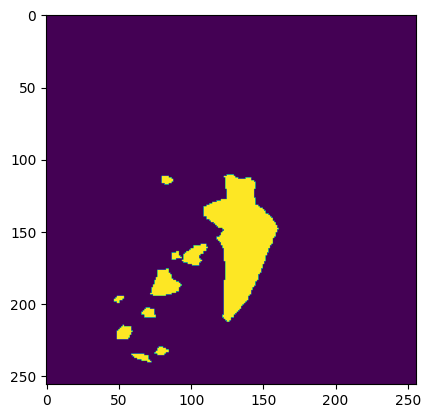

In [7]:
img=plt.imread(train_df.iloc[0,1])
plt.imshow(img)#visualizing the image

In [8]:
from sklearn.model_selection import train_test_split
# Splitting the dataset into training and validation sets.
train_df1, val_df1 = train_test_split(train_df, test_size=0.2, random_state=42)
print(f"Train dataset shape: {train_df1.shape}")
print(f"Validation dataset shape: {val_df1.shape}")

Train dataset shape: (735, 2)
Validation dataset shape: (184, 2)


In [9]:
from torch.utils.data import Dataset
from PIL import Image

class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths=None, transforms=None):
        self.image_paths = image_paths  # List of file paths to the images
        self.mask_paths = mask_paths  # Optional: List of file paths to the segmentation masks
        self.transforms = transforms  # Optional: Transformations to be applied on the images and masks

    def __len__(self):
        return len(self.image_paths)  # Returns the size of the dataset

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')  # Load the image and convert to RGB
        if self.transforms is not None:
            image = self.transforms(image)  # Apply transformations to the image
        
        if self.mask_paths is not None:
            mask = Image.open(self.mask_paths[idx]).convert('L')  # Load the mask and convert to grayscale
            mask = self.transforms(mask)  # Apply transformations to the mask
            return image, mask  # Return the transformed image and mask
        return image  # Return only the transformed image if no mask_paths are provided


In [10]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.Resize((256, 256)),#resize the images 
    transforms.ToTensor(),# Convert images to PyTorch tensors
])


In [11]:
df2=pd.read_csv('/home/shreyas/Untitled_Folder/extracted_mlds_files/test.csv')
df2=df2.drop(columns=['binary_pred']) # Drop the column named 'binary_pred' from 'df2' DataFrame.
df2['id'] = '/home/shreyas/Untitled_Folder/extracted_mlds_files/test/test/'+df2['id'].astype(str)
# Update the 'id' column of 'df2' by prefixing a specific path to each 'id' value and ensure 'id' values are of string type.
df2

id  segmentation_pred
0    /home/shreyas/Untitled_Folder/extracted_mlds_f...                NaN
1    /home/shreyas/Untitled_Folder/extracted_mlds_f...                NaN
2    /home/shreyas/Untitled_Folder/extracted_mlds_f...                NaN
3    /home/shreyas/Untitled_Folder/extracted_mlds_f...                NaN
4    /home/shreyas/Untitled_Folder/extracted_mlds_f...                NaN
..                                                 ...                ...
389  /home/shreyas/Untitled_Folder/extracted_mlds_f...                NaN
390  /home/shreyas/Untitled_Folder/extracted_mlds_f...                NaN
391  /home/shreyas/Untitled_Folder/extracted_mlds_f...                NaN
392  /home/shreyas/Untitled_Folder/extracted_mlds_f...                NaN
393  /home/shreyas/Untitled_Folder/extracted_mlds_f...                NaN

[394 rows x 2 columns]

In [12]:
import os  
os.makedirs('/home/shreyas/Untitled_Folder/extracted_mlds_files/', exist_ok=True)  
df2.to_csv('/home/shreyas/Untitled_Folder/extracted_mlds_files/test_image_seg.csv') 

In [13]:

image_paths = train_df1['image_path'].tolist()  # Convert the DataFrame column to a list
mask_paths = train_df1['mask_path'].tolist()    # Same for mask paths
#create the dataset
train_dataset = SegmentationDataset(image_paths=image_paths, mask_paths=mask_paths, transforms=transform)


In [14]:
image_paths = val_df1['image_path'].tolist()  # Convert the DataFrame column to a list
mask_paths = val_df1['mask_path'].tolist()    # Same for mask paths
# create the dataset
val_dataset = SegmentationDataset(image_paths=image_paths, mask_paths=mask_paths, transforms=transform)


In [15]:
image_paths = df2['id'].tolist()  # Convert the DataFrame column to a list
#mask_paths = df2['mask_path'].tolist()    # Same for mask paths

# create the dataset
test_dataset = SegmentationDataset(image_paths=image_paths, mask_paths=None, transforms=transform)


torch.Size([256, 256])

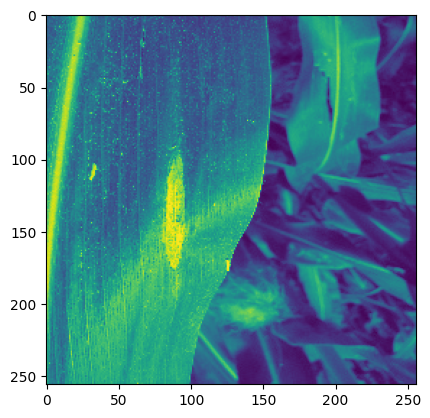

In [48]:
img=test_dataset[4][0]
plt.imshow(img)
img.shape
#visualize the image in test_dataset

In [17]:
# Creating a DataLoader for the training,val and test dataset with a batch size of 8
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader =DataLoader(test_dataset, batch_size=8, shuffle=False)

In [18]:
len(train_loader),len(val_loader),len(test_loader)

(92, 23, 50)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/pytorch/pytorch/issues/20503
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [25]:
# import torch
# import torch.nn as nn

# class DoubleConv(nn.Module):
#     """(convolution => [BN] => ReLU) * 2"""

#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.double_conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         return self.double_conv(x)

# class UNet(nn.Module):
#     def __init__(self, n_channels, n_classes):
#         super(UNet, self).__init__()
#         self.n_channels = n_channels
#         self.n_classes = n_classes

#         self.inc = DoubleConv(n_channels, 64)
#         self.down1 = DoubleConv(64, 128)
#         self.down2 = DoubleConv(128, 256)
#         self.down3 = DoubleConv(256, 512)
#         self.up1 = DoubleConv(256 + 512, 256)
#         self.up2 = DoubleConv(128 + 256, 128)
#         self.up3 = DoubleConv(128 + 64, 64)
#         self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

#     def forward(self, x):
#         x1 = self.inc(x)
#         x2 = self.down1(x1)
#         x3 = self.down2(x2)
#         x4 = self.down3(x3)
#         x = self.up1(torch.cat([x3, x4], dim=1))
#         x = self.up2(torch.cat([x2, x], dim=1))
#         x = self.up3(torch.cat([x1, x], dim=1))
#         logits = self.outc(x)
#         return logits


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [27]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np

# Initialize the above U-Net model with 1 input channel and 1 output class for binary segmentation
model = UNet(n_channels=1, n_classes=1)  

# Now move the model to a specified computing device (CUDA)
model.to(device)

# Set the loss function to Binary Cross Entropy with Logits, suitable for binary segmentation tasks
criterion = nn.BCEWithLogitsLoss()  

# The optimizer to use the Adam algorithm for minimizing loss, with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)


Epoch 1, Train Loss: 0.2185, Train Acc: 0.9215, Val Loss: 0.2382, Val Acc: 0.9241
Epoch 2, Train Loss: 0.2327, Train Acc: 0.9216, Val Loss: 0.2388, Val Acc: 0.9240
Epoch 3, Train Loss: 0.2211, Train Acc: 0.9215, Val Loss: 0.2146, Val Acc: 0.9241
Epoch 4, Train Loss: 0.2242, Train Acc: 0.9216, Val Loss: 0.2386, Val Acc: 0.9241
Epoch 5, Train Loss: 0.2141, Train Acc: 0.9217, Val Loss: 0.2588, Val Acc: 0.9217
Epoch 6, Train Loss: 0.2136, Train Acc: 0.9223, Val Loss: 0.2023, Val Acc: 0.9241
Epoch 7, Train Loss: 0.2132, Train Acc: 0.9212, Val Loss: 0.2301, Val Acc: 0.9242
Epoch 8, Train Loss: 0.2210, Train Acc: 0.9218, Val Loss: 0.2241, Val Acc: 0.9223
Epoch 9, Train Loss: 0.2097, Train Acc: 0.9213, Val Loss: 0.2707, Val Acc: 0.9241
Epoch 10, Train Loss: 0.2116, Train Acc: 0.9223, Val Loss: 0.2318, Val Acc: 0.9219


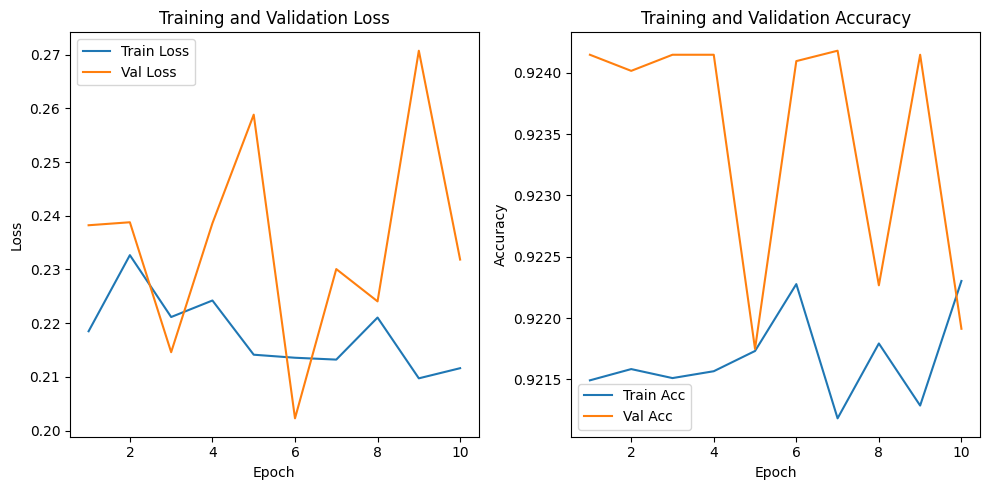

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Lists to store per-epoch loss and accuracy for both train and val loops
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Calculate accuracy of predictions: Apply sigmoid and threshold at 0.5 to determine prediction
def calc_accuracy(outputs, labels):
    preds = torch.sigmoid(outputs) > 0.5
    correct = (preds == labels).float() # Compare predictions to true labels
    acc = correct.sum() / correct.numel()
    return acc

num_epochs = 25

for epoch in range(num_epochs):
    model.train() # Sets model to training mode
    running_loss = 0.0
    running_accuracy = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()#clear grads
        outputs = model(inputs)#forward passes
        loss = criterion(outputs, labels)#calculates losses
        acc = calc_accuracy(outputs, labels)#calculates accuracy
        
        loss.backward()#backpropagation
        optimizer.step()#update model params
        
        running_loss += loss.item()# add up batch loss
        running_accuracy += acc.item()# add up batch accuracy
    # Calculate average loss and accuracy over an epoch
    train_loss = running_loss / len(train_loader)
    train_acc = running_accuracy / len(train_loader)
    # Store training loss and accuracy
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_accuracy = 0.0
    
    with torch.no_grad(): # no grads are calculated
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            acc = calc_accuracy(outputs, labels)
            
            val_running_loss += loss.item()# add up batch loss
            val_running_accuracy += acc.item() # add up batch accuracy
    # Calculate average loss and accuracy over the validation set
    val_loss = val_running_loss / len(val_loader)
    val_acc = val_running_accuracy / len(val_loader)
    # Store validation loss and accuracy
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
epochs = range(1, num_epochs + 1)
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def mask2rle(img):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formatted
    """
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


model.eval()  # Set the model to evaluation mode
predictions = []

with torch.no_grad():  # No gradients needed
    for inputs in test_loader:
        inputs = inputs.to(device)  # Move inputs to the device
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
        outputs = (outputs > 0.5).float()  # Threshold probabilities to get binary mask
        outputs = outputs.squeeze().cpu().numpy()  # Move predictions back to CPU and convert to numpy array
        
        # Iterate through each item in the batch (if your test_loader has a batch size > 1)
        for output in outputs:
            rle_encoded = mask2rle(output.astype(np.uint8))  # Encode mask
            predictions.append(rle_encoded)


In [ ]:
import pandas as pd

# Assuming test_df is the DataFrame loaded from 'test_image_seg.csv' which contains the image IDs
# Make sure the 'id' column in test_df corresponds to the order of images you've made predictions for
test_df['segmentation_pred'] = predictions
submission_file_path = '/path/to/your_submission.csv'  # Specify your desired path
test_df.to_csv(submission_file_path, index=False)


In [30]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    epoch_loss = running_loss / len(loader)
    return epoch_loss


In [31]:
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            running_loss += loss.item()

    epoch_loss = running_loss / len(loader)
    return epoch_loss


In [32]:
num_epochs = 25

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, val_loader, criterion, device)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch 1, Train Loss: 0.2123, Val Loss: 0.2047
Epoch 2, Train Loss: 0.2085, Val Loss: 0.2242
Epoch 3, Train Loss: 0.2017, Val Loss: 0.2140
Epoch 4, Train Loss: 0.1958, Val Loss: 0.2102
Epoch 5, Train Loss: 0.1990, Val Loss: 0.2067
Epoch 6, Train Loss: 0.2033, Val Loss: 0.2297
Epoch 7, Train Loss: 0.1946, Val Loss: 0.2023
Epoch 8, Train Loss: 0.1934, Val Loss: 0.2203
Epoch 9, Train Loss: 0.1928, Val Loss: 0.2519
Epoch 10, Train Loss: 0.1897, Val Loss: 0.2000
Epoch 11, Train Loss: 0.1908, Val Loss: 0.1958
Epoch 12, Train Loss: 0.1884, Val Loss: 0.2118
Epoch 13, Train Loss: 0.1904, Val Loss: 0.1891
Epoch 14, Train Loss: 0.1778, Val Loss: 0.2024
Epoch 15, Train Loss: 0.1821, Val Loss: 0.1999
Epoch 16, Train Loss: 0.1783, Val Loss: 0.2375
Epoch 17, Train Loss: 0.1881, Val Loss: 0.2265
Epoch 18, Train Loss: 0.1831, Val Loss: 0.2020
Epoch 19, Train Loss: 0.1793, Val Loss: 0.2242
Epoch 20, Train Loss: 0.1827, Val Loss: 0.1918
Epoch 21, Train Loss: 0.1818, Val Loss: 0.1945
Epoch 22, Train Loss: 

In [34]:
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(epochs, train_loss, label='Train Loss')
# plt.plot(epochs, val_loss, label='Val Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

In [35]:
def mask2rle(img):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formatted
    """
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


model.eval()  # Set the model to evaluation mode
predictions = []

with torch.no_grad():  # No gradients needed
    for inputs in test_loader:
        inputs = inputs.to(device)  # Move inputs to the device
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
        outputs = (outputs > 0.5).float()  # Threshold probabilities to get binary mask
        outputs = outputs.squeeze().cpu().numpy()  # Move predictions back to CPU and convert to numpy array
        
        # Iterate through each item in the batch (if your test_loader has a batch size > 1)
        for output in outputs:
            rle_encoded = mask2rle(output.astype(np.uint8))  # Encode mask
            predictions.append(rle_encoded)


In [47]:
import pandas as pd

# Assuming test_df is the DataFrame loaded from 'test_image_seg.csv' which contains the image IDs
# Make sure the 'id' column in test_df corresponds to the order of images you've made predictions for
df2['segmentation_pred'] = predictions
submission_file_path = '/home/shreyas/Untitled_Folder/extracted_mlds_files/test_submission.csv'  # Specify your desired path
df2.to_csv(submission_file_path, index=False)

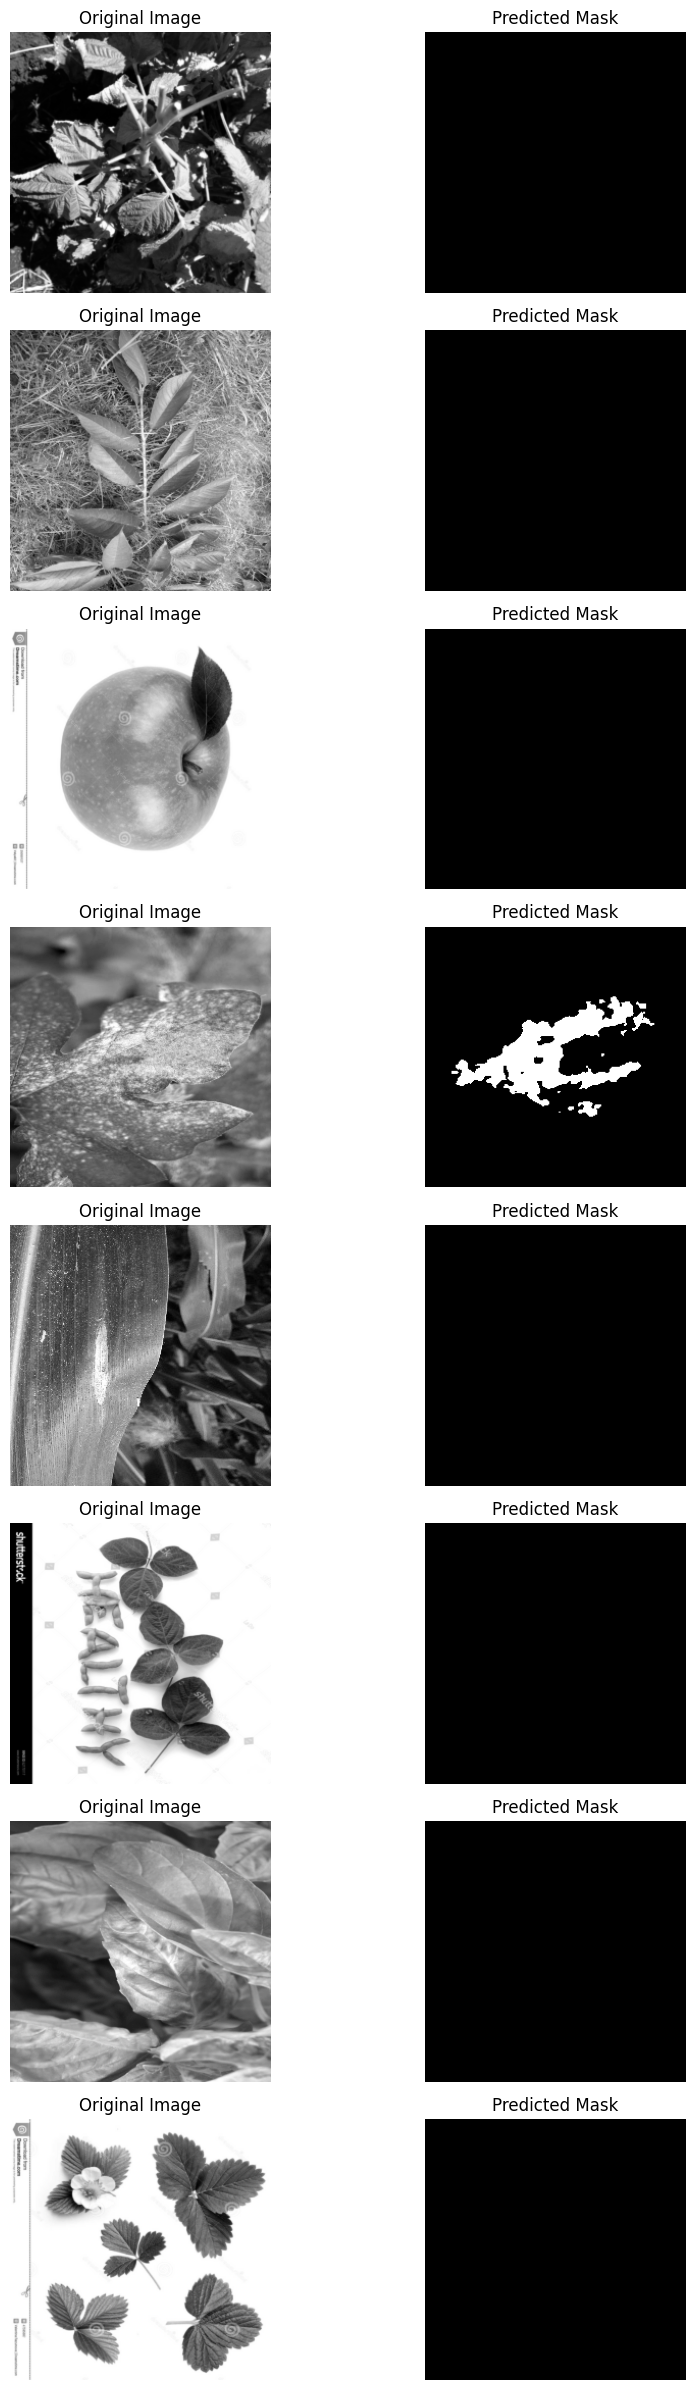

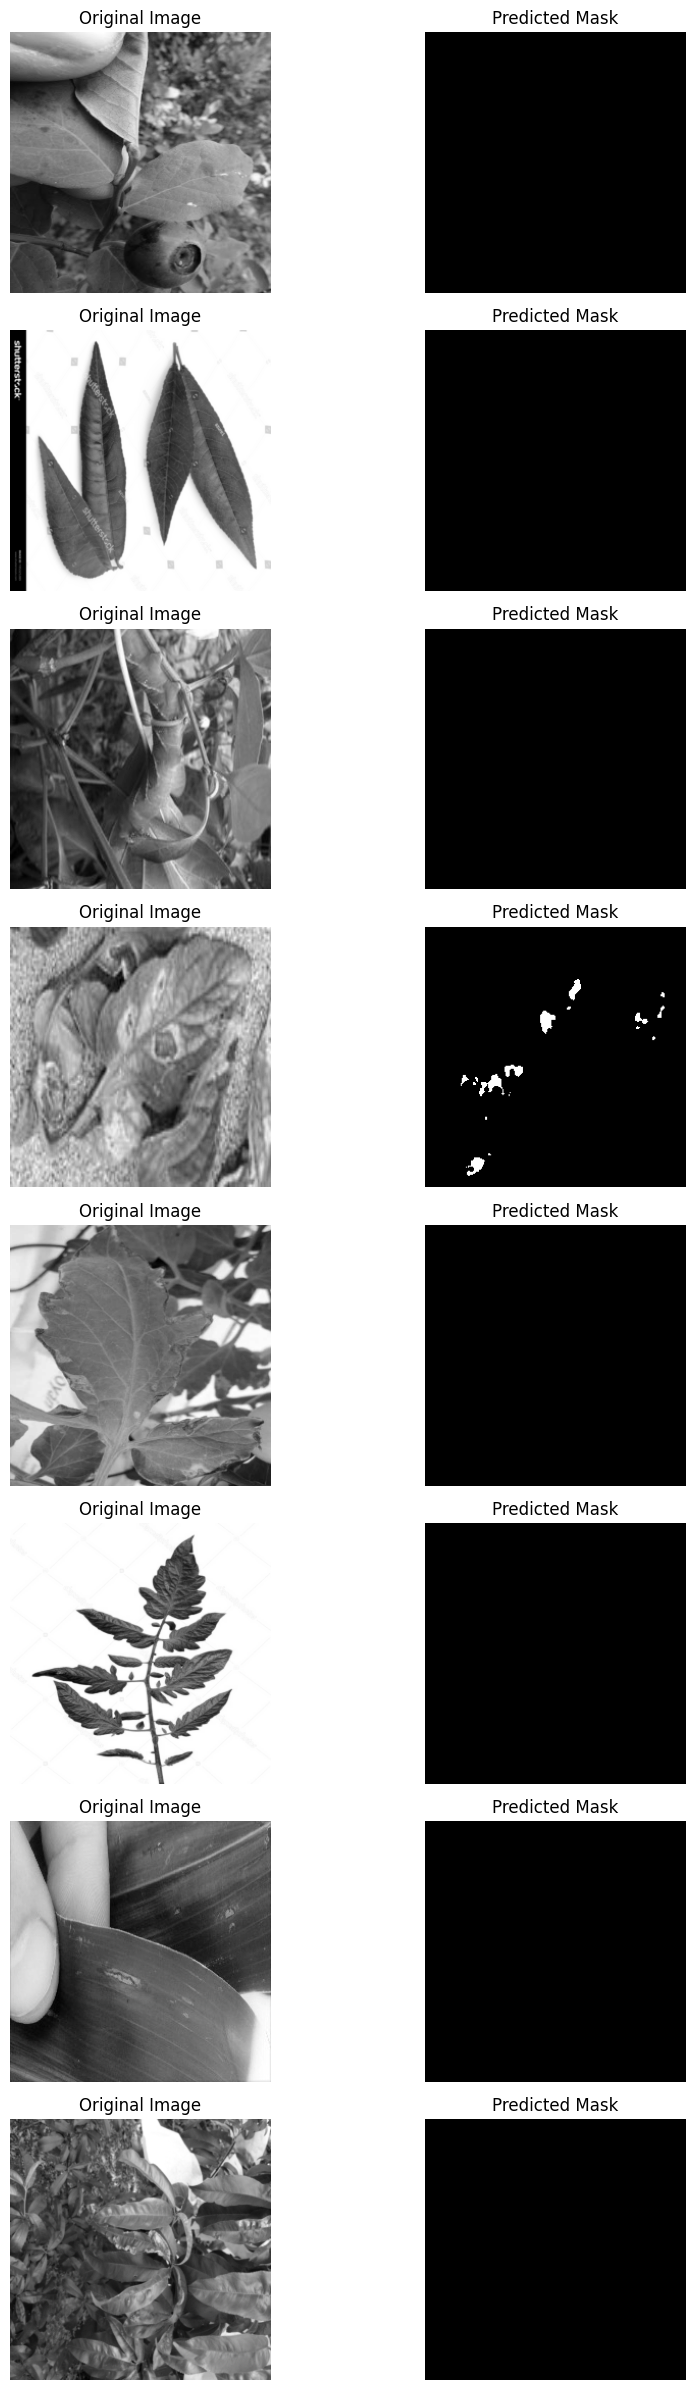

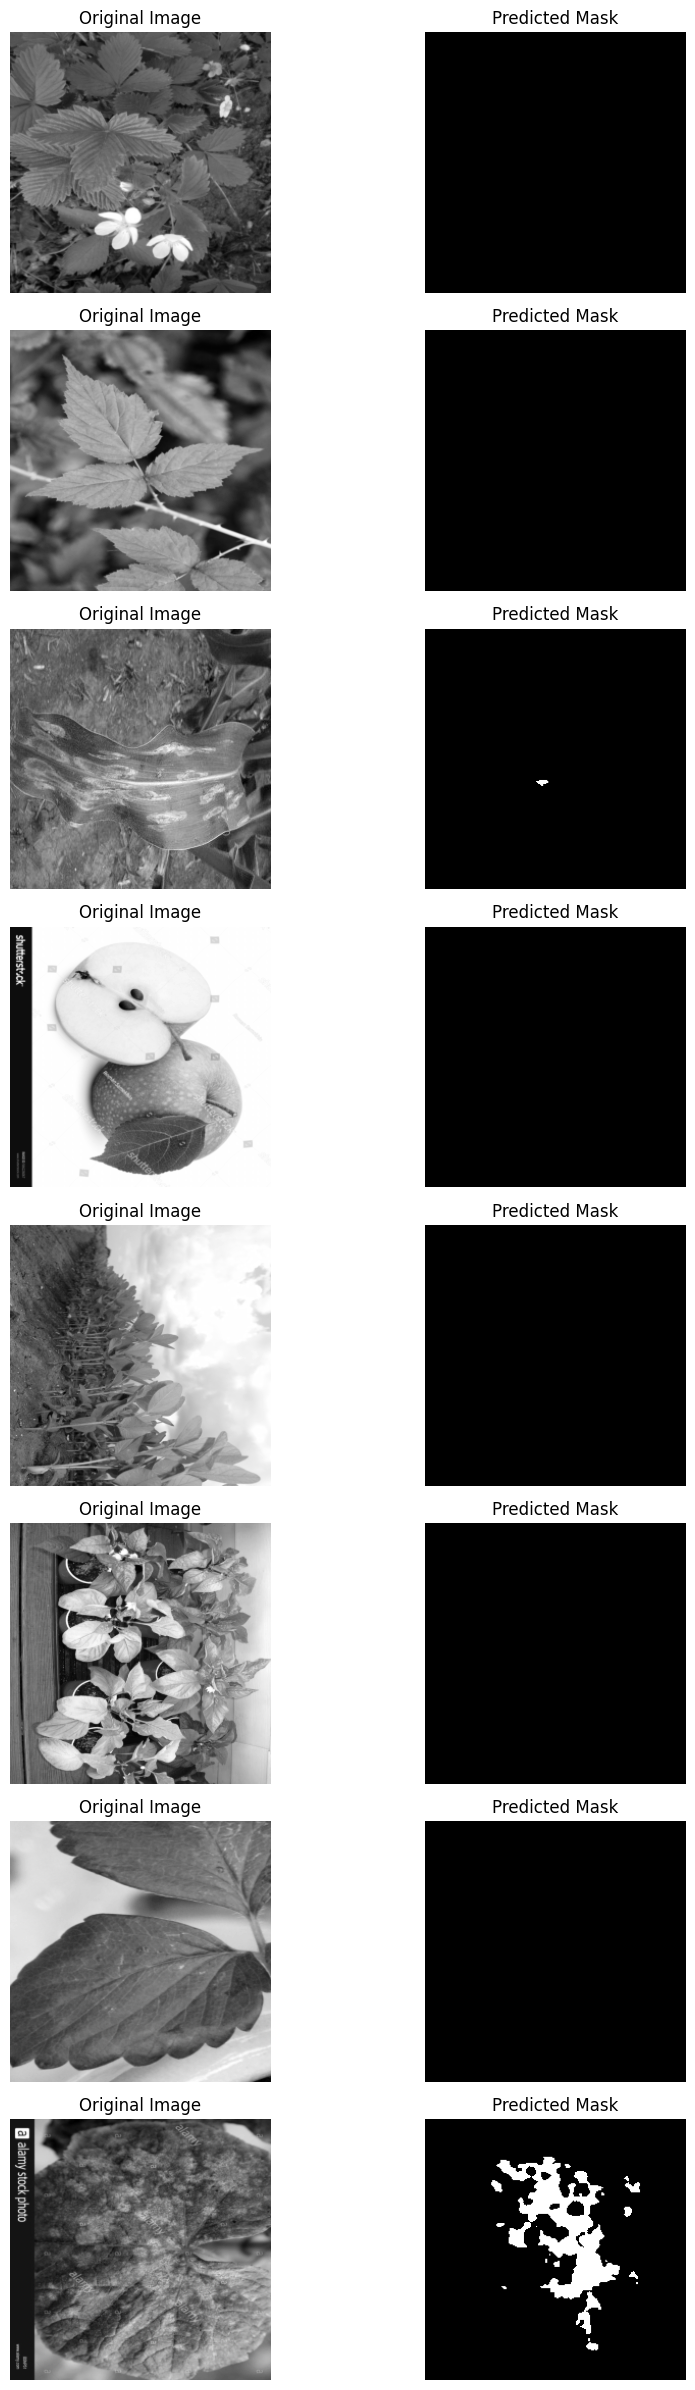

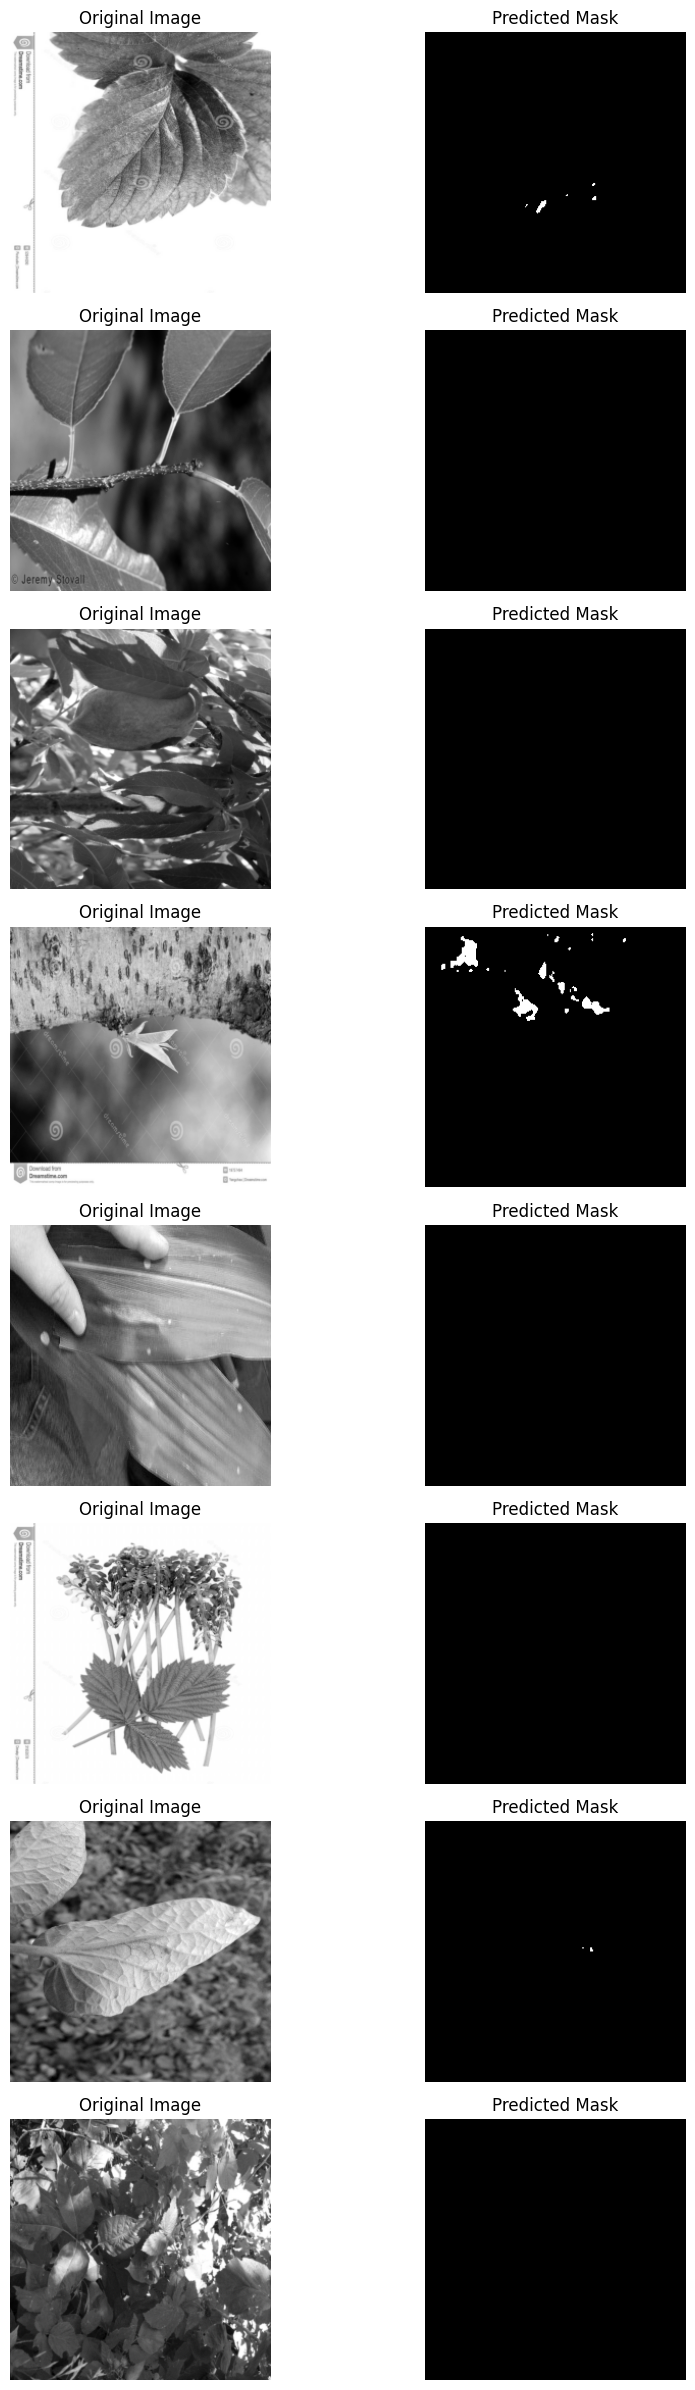

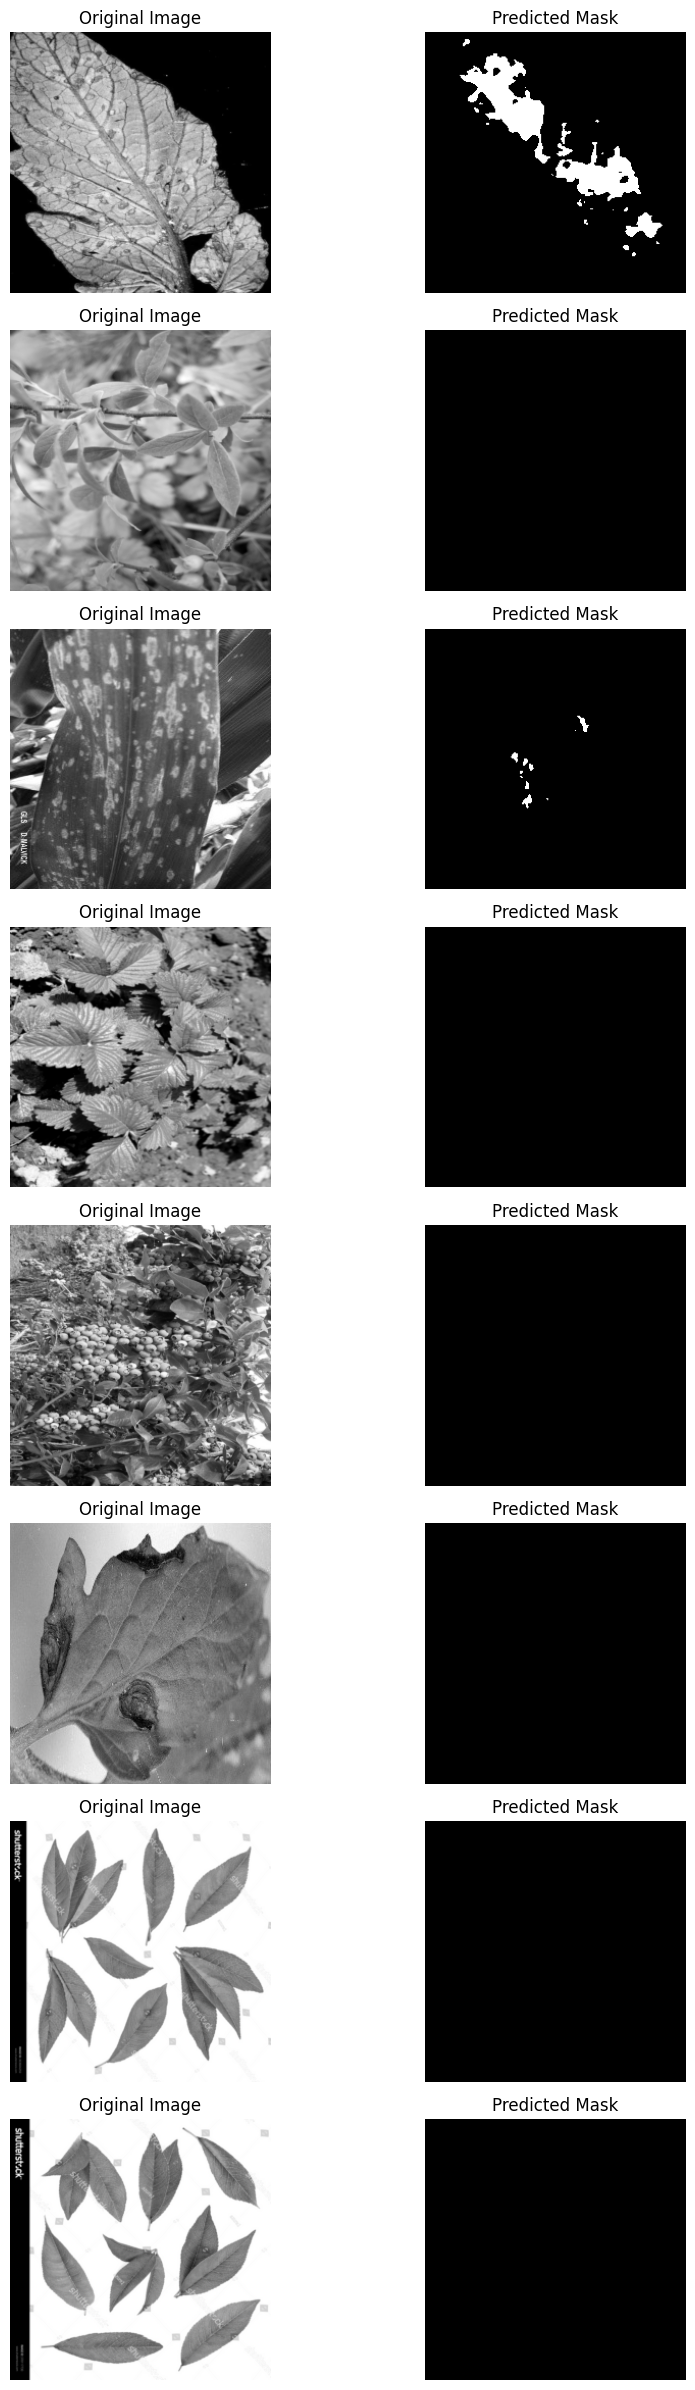

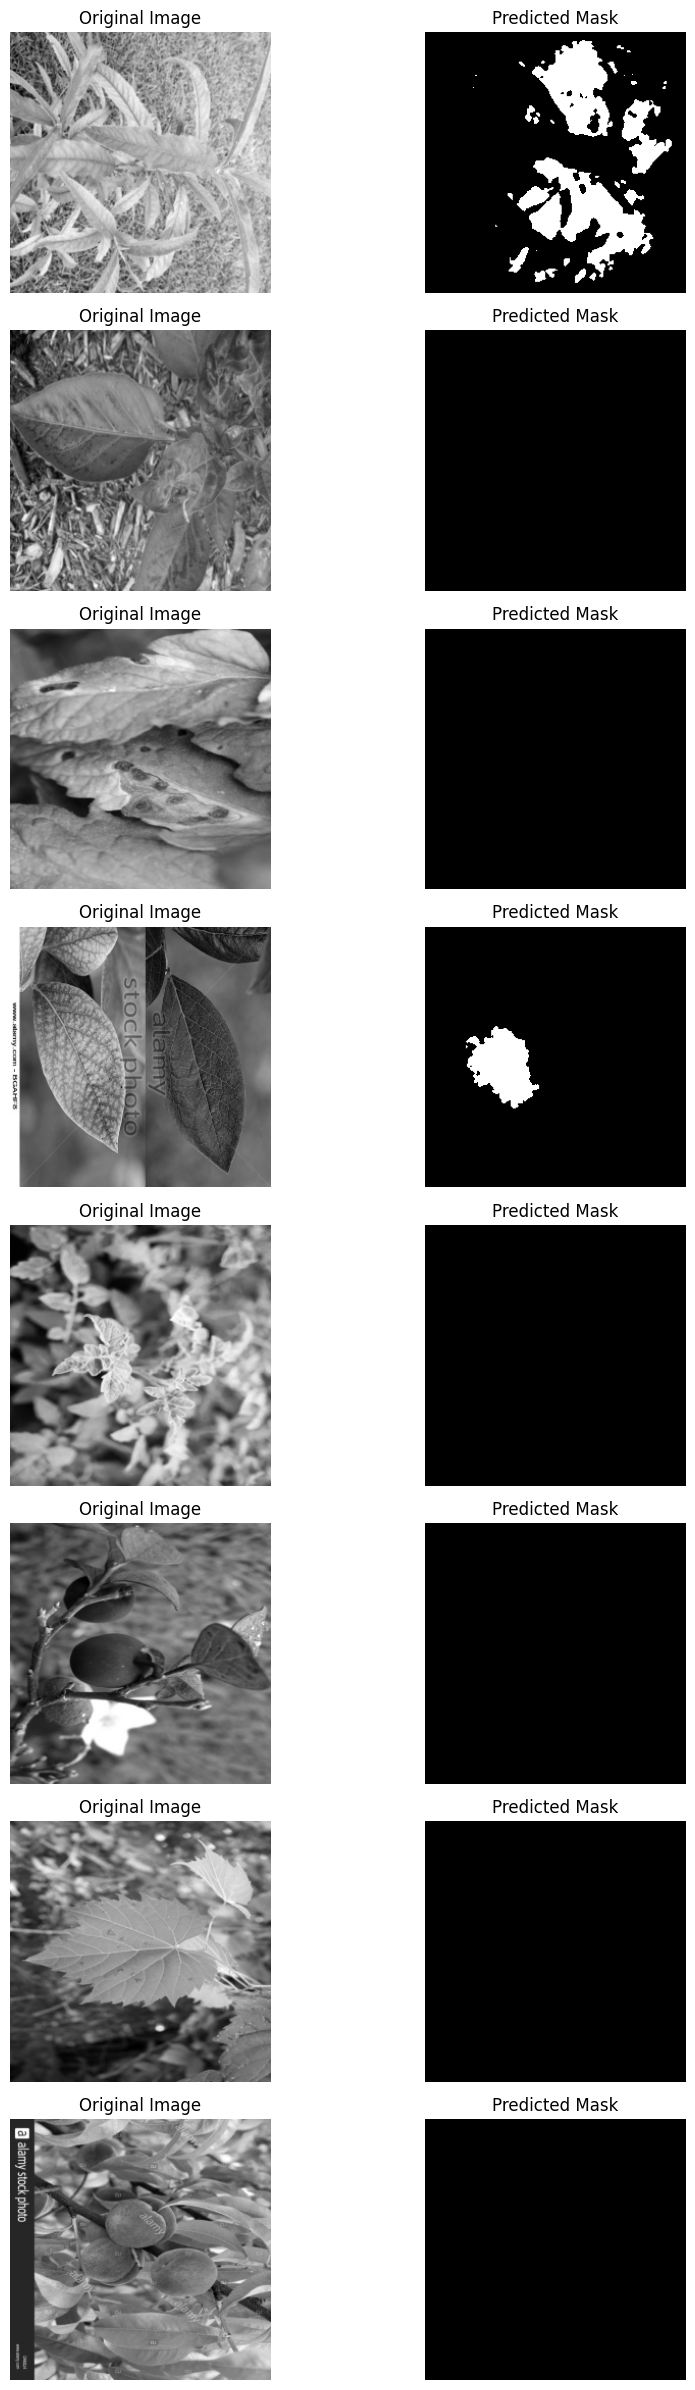

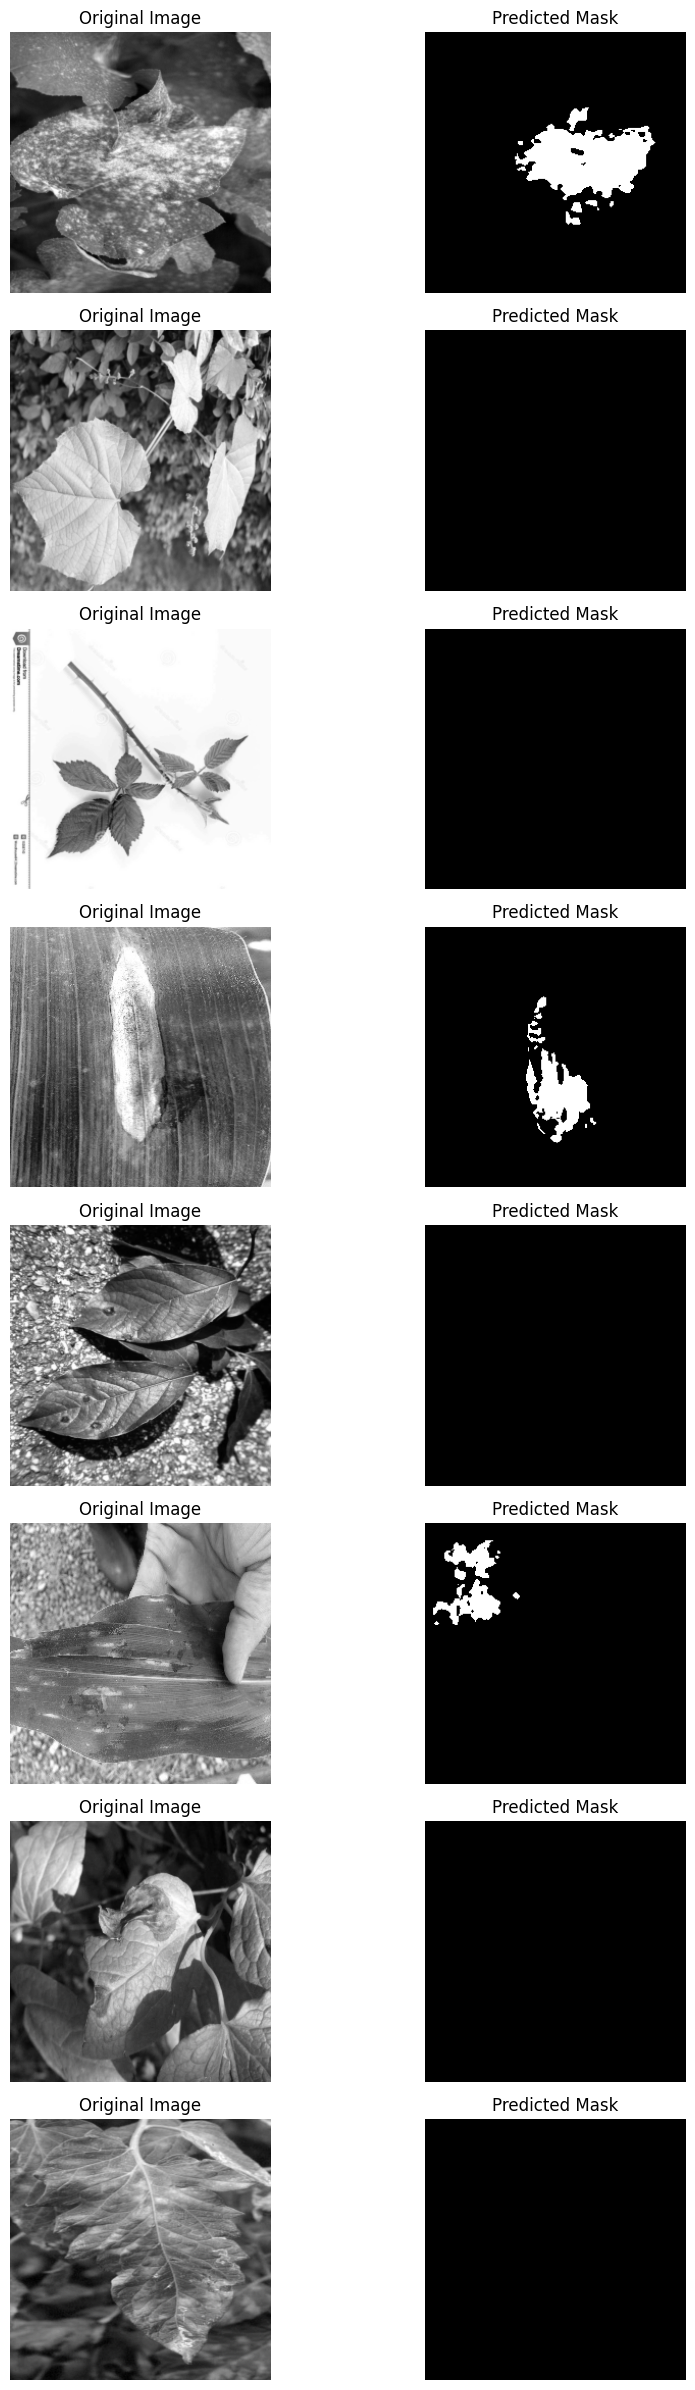

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_predictions_paginated(model, loader, device, num_images, page_size=10):
    model.eval()
    images_processed = 0

    for images_batch in loader:
        images_batch = images_batch.to(device)
        
        with torch.no_grad():
            outputs = model(images_batch)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()  # Apply threshold to get binary mask
        
        images_batch, preds = images_batch.cpu(), preds.cpu()
        batch_size = images_batch.size(0)
        
        for batch_index in range(0, batch_size, page_size):
            if images_processed >= num_images:
                return  # Exit if we've processed the required number of images
            
            actual_page_size = min(page_size, batch_size - batch_index)
            fig, axs = plt.subplots(actual_page_size, 2, figsize=(10, actual_page_size * 3))
            
            for page_index in range(actual_page_size):
                image_index = batch_index + page_index
                if images_processed >= num_images:
                    plt.close(fig)  # Close the figure to prevent displaying incomplete figures
                    return  # Exit if we've processed the required number of images
                
                if actual_page_size == 1:
                    axs = [axs]  # Make sure axs is iterable
                
                axs[page_index, 0].imshow(images_batch[image_index].squeeze(), cmap='gray')
                axs[page_index, 0].set_title('Original Image')
                axs[page_index, 1].imshow(preds[image_index].squeeze(), cmap='gray')
                axs[page_index, 1].set_title('Predicted Mask')
                
                for ax in axs[page_index]:
                    ax.axis('off')
            
            images_processed += actual_page_size
            plt.tight_layout()
            plt.show()

# Example call
visualize_predictions_paginated(model, test_loader, device, num_images=50, page_size=10)
